In [1]:
import os
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
from PIL import Image as im
from PIL import Image
import shutil

In [3]:
root=os.getcwd()
os.makedirs("Experiment2/All_Butter_Fly_Images",exist_ok=True)
All_Images_Folder=root+"/Experiment2/All_Butter_Fly_Images/"
Original_Image_Folder=root+"/ButterFly/"

#copyAllImages(Original_Image_Folder,All_Images_Folder)

In [20]:
def copyAllImages(Original_Image_Folder,target_Folder):
    count=0
    for file in os.scandir(Original_Image_Folder):
        if file.is_dir():
            count=count+copyAllImages(file,target_Folder)
        else:
            shutil.copy(file, target_Folder)
            count=count+1
    return count

In [35]:
#make pair file
f=open(root+"/Experiment2/Experiment2_pairs.txt",'w')
count=0

for file in os.scandir(All_Images_Folder):
    for file2 in os.scandir(All_Images_Folder):
        if file.name== file2.name:
            continue
        else:
            im1_path=file.path.removeprefix(root+"/")
            im2_path=file2.path.removeprefix(root+"/")
            f.write(im1_path+" "+im2_path+"\n")
            count=count+1;
print(count)
f.close()

147072


In [9]:
file1=open(root+"/Experiment2/Experiment2_pairs.txt",'r')
file2=open(root+"/Experiment2/Experiment2_pairs_left.txt",'w')
Lines = file1.readlines()
  
count = 0
for line in Lines:
    count += 1
    if count <114000:
        continue;
    else:
        file2.write(line)
file1.close()
file2.close()

file2=open(root+"/Experiment2/Experiment2_pairs_left.txt",'r')
Lines=file2.readlines()
count=0
for line in Lines:
    count+=1
print(count)

33073


In [25]:
def createNpzFileWithClassName(Original_Image_Folder,class_name,file_class_list):
    for file in os.scandir(Original_Image_Folder):
        if file.is_dir():
            file_class_list=createNpzFileWithClassName(file,file.name,file_class_list)
        else:
            file_class_list.append([file.name,class_name])
    return file_class_list

In [58]:
file_class_list=[]
file_class_list=createNpzFileWithClassName(Original_Image_Folder,"",file_class_list)
imgName_className = np.array(file_class_list)
[row,col]=imgName_className.shape

count=0

for i in range(row):
    for j in range(row):
        if imgName_className[i,0]==imgName_className[j,0]:
            continue
        else:
            count+=1
print(len(file_class_list))
np.savez("Experiment2/ImageName_ClassName_List", imgName_className)

384


In [103]:
file1=open(root+"/Experiment2/Experiment2_pairs.txt",'r')
Lines = file1.readlines()
count=0
npzTableWithClass=np.zeros((384,385),dtype='U100')

for line in Lines:
    count+=1
    words=line.split()
    image_1_name=words[0].removeprefix("Experiment2/All_Butter_Fly_Images/")
    image_1_name=image_1_name.removesuffix(".png")
    image_2_name=words[1].removeprefix("Experiment2/All_Butter_Fly_Images/")
    image_2_name=image_2_name.removesuffix(".png")
    path="Experiment2/All_npzs/"+image_1_name+"_"+image_2_name+"_matches.npz"
    [ClassName_of_img1,img1Pos]=getClassName(image_1_name+".png",imgName_className)
    [ClassName_of_img2,img2Pos]=getClassName(image_2_name+".png",imgName_className)
    npzTableWithClass[img1Pos,img2Pos]=path
    npzTableWithClass[img1Pos,384]=ClassName_of_img1
               

In [59]:
def getClassName(str,imgName_className):
    [row, col]=imgName_className.shape
    for r in range(row):
        if imgName_className[r,0] == str:
            return imgName_className[r,1],r
        else:
            continue

In [105]:
no_string=0
for i in range(384):
    for j in range(385):
        #print(npzTableWithClass[i,j])
        if npzTableWithClass[i,j]=="":
            no_string+=1
print(no_string)
np.savez("Experiment2/2D_list_of_all_npzs_with_class", npzTableWithClass)    

384


In [107]:
import numpy as np

path = 'Experiment2/MatchNumbersTable.npz'
npzMatch = np.load(path)
path = 'Experiment2/2D_list_of_all_npzs_with_class.npz'
npz = np.load(path)
class_name_indexed=npz['arr_0'][:,384]
class_name_set=list(set(class_name_indexed))


In [368]:
import math
def getPredictedResults(matchValueArray, class_name_indexed,how_much_to_consider,current_index):
    
    predicIndex=0
    originalIndex=0
    
    
    dic= {}
    for i in range(384):
        dic[i]=[]
        dic[i].append(matchValueArray[i])
        
    dic=dict(sorted(dic.items(), key=lambda item: item[1],reverse=True))
    #how_much_to_consider=math.ceil(len(dic)*.2)
    firstNvals = [v for v in list(dic.keys())[:how_much_to_consider]]
    results=list(class_name_indexed[firstNvals])
    
    ans=max(results,key=results.count)
    if ans== class_name_indexed[current_index]:
        return 1,originalIndex,predicIndex
    else:
        for j in range(27):
            if class_name_set[j]==ans:
                predicIndex=j
            if class_name_indexed[current_index]==class_name_set[j]:
                originalIndex=j
        return 0,originalIndex,predicIndex


In [369]:
def do_knn(k):
    rows, cols = (27, 27)
    arr = list(np.zeros((rows,cols)))
    accurate_results=0
    y=list(np.zeros(len(class_name_set)))

    for i in range(384):
        matchValueArray=npzMatch['arr_0'][i,:]
        [res,originalIndex,predicIndex]=getPredictedResults(matchValueArray,class_name_indexed,k,i)
        if res!=1:
            y[class_name_set.index(class_name_indexed[i])]+=1
            arr[originalIndex][predicIndex]+=1
        accurate_results+=res
        
    print("overall_accuracy = ",(accurate_results/384)*100)
    print("wrongly Answered:" ,384-accurate_results)
    
#    for i in range(27):
#        for j in range(27):
#            if arr[i][j]!=0:
#                print()
#                print(class_name_set[i]," = ",end=' ')
#                break
#        for j in range(27):
#            if arr[i][j]!=0:
#                print(class_name_set[j],"= ",arr[i][j],",",end=' ')

    mimic_pair_error=0
    
    for i in range(12):
        for j in range(27):
            if class_name_set[j] == mimic_pairs[i][0]:
                for k in range(27):
                    if class_name_set[k] == mimic_pairs[i][1] and arr[j][k]!=0:
                        mimic_pair_error+=arr[j][k]
        for j in range(27):
            if class_name_set[j] == mimic_pairs[i][1]:
                for k in range(27):
                    if class_name_set[k] == mimic_pairs[i][0] and arr[k][j]!=0:
                        mimic_pair_error+=arr[k][j]  
    print("mimic_pair_accuracy = ",((404-mimic_pair_error)/404)*100)
    print("wrn: ",mimic_pair_error)
    #return y

In [370]:
#print(class_name_indexed.shape)
do_knn(4)

overall_accuracy =  87.23958333333334
wrongly Answered: 49
mimic_pair_accuracy =  99.5049504950495
wrn:  2.0


86.45833333333334
wrongly Answered: 52

erato_etylus  =  erato_lativitta =  2.0 , erato_emma =  1.0 , 
melpomene_ecuadorensis  =  melpomene_schunkei =  3.0 , melpomene_aglaope =  2.0 , 
erato_petiverana  =  erato_hydara =  1.0 , 
erato_venus  =  erato_petiverana =  1.0 , erato_hydara =  1.0 , erato_favorinus =  2.0 , erato_phyllis =  1.0 , 
melpomene_xenoclea  =  melpomene_plesseni =  1.0 , 
erato_guarica  =  erato_hydara =  2.0 , 
erato_microclea  =  melpomene_xenoclea =  1.0 , 
melpomene_melpomene  =  erato_hydara =  1.0 , melpomene_rosina_S =  1.0 , melpomene_vulcanus =  1.0 , 
erato_emma  =  erato_lativitta =  2.0 , 
melpomene_schunkei  =  melpomene_ecuadorensis =  1.0 , melpomene_aglaope =  3.0 , 
melpomene_rosina_N  =  melpomene_amaryllis =  1.0 , melpomene_rosina_S =  2.0 , melpomene_vulcanus =  1.0 , 
erato_notabilis  =  melpomene_plesseni =  3.0 , 
erato_erato  =  erato_lativitta =  1.0 , 
erato_colombina  =  erato_petiverana =  1.0 , erato_hydara =  1.0 , 
erato_luscombei  = 

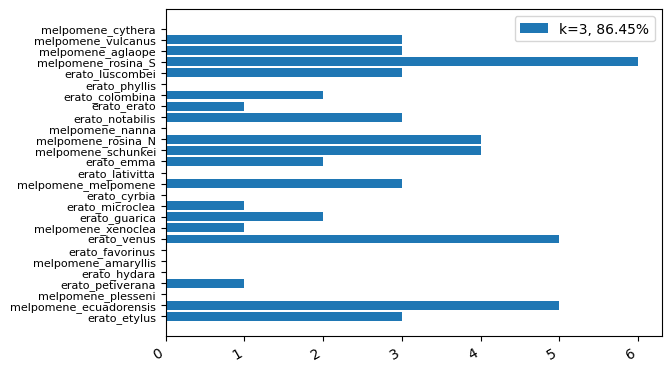

0.0


In [341]:
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates


#plt.barh(class_name_set,do_knn(1),label = "k=1, 85.94%")
plt.barh(class_name_set,do_knn(3),label = "k=3, 86.45%")
#plt.plot(do_knn(3),class_name_set,label = "k=3, 86.46%")
#plt.plot(do_knn(4),class_name_set,label = "k=4, 87.24%")
plt.tick_params(axis='y', which='major', labelsize=8)

# Avoid overlapping

plt.gcf().autofmt_xdate()
plt.legend()

# Visualize

plt.show()
print(sum(y))

In [290]:
mimic_pairs=\
[["erato_petiverana","melpomene_rosina_S"],
["erato_hydara","melpomene_melpomene"],
["erato_venus","melpomene_vulcanus"],
["erato_cyrbia","melpomene_cythera"],
["erato_notabilis","melpomene_plesseni" ],
["erato_etylus","melpomene_ecuadorensis"],
["erato_emma","melpomene_aglaope"],
["erato_favorinus","melpomene_amaryllis"],
["erato_microclea","melpomene_xenoclea"],
["erato_luscombei","melpomene_schunkei"],
["erato_phyllis","Burchelli"],
["erato_phyllis","melpomene_nanna"]]
print(mimic_pairs[1][0])

erato_hydara


In [327]:
import math
def getPredictedResultsM(matchValueArray, class_name_indexed,how_much_to_consider,current_index,pairN1,pairN2):
    
    predicIndex=0
    originalIndex=0
    
    
    dic= {}
    for i in range(384):
        if class_name_indexed[i]==pairN1 or class_name_indexed[i]==pairN2:
            dic[i]=[]
            dic[i].append(matchValueArray[i])
        
    dic=dict(sorted(dic.items(), key=lambda item: item[1],reverse=True))
    how_much_to_consider=math.ceil(len(dic)*(how_much_to_consider/100))
    #how_much_to_consider=len(dic)
    firstNvals = [v for v in list(dic.keys())[:how_much_to_consider]]
    results=list(class_name_indexed[firstNvals])
    
    ans=max(results,key=results.count)
    if ans== class_name_indexed[current_index]:
        return 1,originalIndex,predicIndex
    else:
        print(class_name_indexed[current_index],"= ",results)
        for j in range(27):
            if class_name_set[j]==ans:
                predicIndex=j
            if class_name_indexed[current_index]==class_name_set[j]:
                originalIndex=j
        return 0,originalIndex,predicIndex

In [328]:
def do_mimic_pair_knn(k):
    total_mimic_pair_instance=0
    accurate_results=0
    for i in range(12):
        for j in range(384):
            if class_name_indexed[j]==mimic_pairs[i][1] or class_name_indexed[j]==mimic_pairs[i][0]:
                total_mimic_pair_instance+=1
                matchValueArray=npzMatch['arr_0'][j,:]
                [res,originalIndex,predicIndex]=getPredictedResultsM(matchValueArray,class_name_indexed,k,j,mimic_pairs[i][1],mimic_pairs[i][0])
                accurate_results+=res
            
    print("for k= 3, accuracy = ",(accurate_results/total_mimic_pair_instance)*100)
    print("Total = ",total_mimic_pair_instance)
    print("wrongly Answered:" ,total_mimic_pair_instance-accurate_results)
    
do_mimic_pair_knn(10)

melpomene_melpomene =  ['erato_hydara', 'erato_hydara', 'erato_hydara', 'erato_hydara', 'erato_hydara', 'erato_hydara']
melpomene_melpomene =  ['melpomene_melpomene', 'erato_hydara', 'erato_hydara', 'erato_hydara', 'erato_hydara', 'erato_hydara']
melpomene_melpomene =  ['erato_hydara', 'erato_hydara', 'erato_hydara', 'erato_hydara', 'erato_hydara', 'erato_hydara']
erato_venus =  ['erato_venus', 'melpomene_vulcanus', 'melpomene_vulcanus']
erato_notabilis =  ['erato_notabilis', 'melpomene_plesseni', 'melpomene_plesseni', 'melpomene_plesseni', 'melpomene_plesseni']
erato_emma =  ['melpomene_aglaope']
for k= 3, accuracy =  98.51485148514851
Total =  404
wrongly Answered: 6
